<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/sharpeRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To using Yahoo finance instead of pandas datareader
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3MB 7.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=654f3323ed4bb7b1c8109958ca3a8a03fd49cb6be6a098a4e2ededce7b623627
  Stored in directory: /tmp/pip-ephem-wheel-cache-oyz899ap/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

# Config display
%config InlineBackend.figure_format = 'retina'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


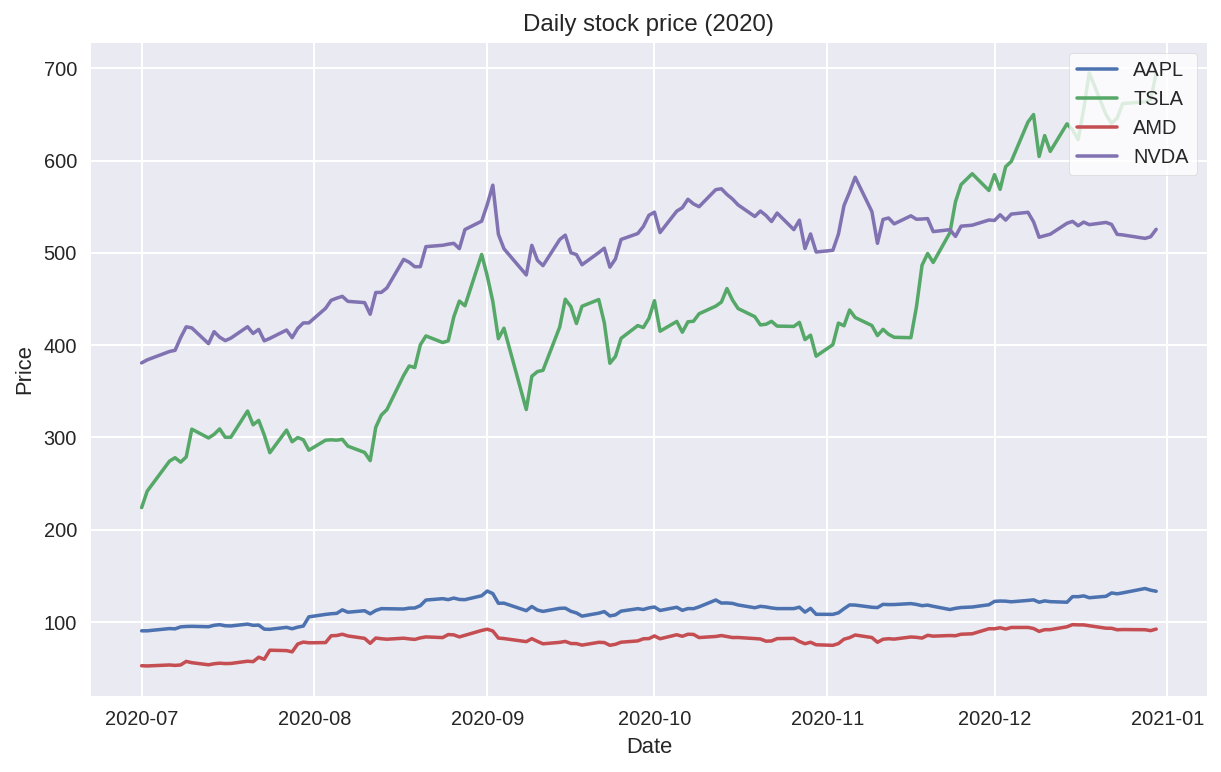

In [3]:
# Get stocks data
stockList = ['AAPL', 'TSLA', 'AMD', 'NVDA']
df = []

for stock in stockList:
  data = yf.download(stock,
                     start = '2020-07-01',
                     end = '2020-12-31')
  data = data[['Adj Close']]
  data = data.rename(columns = {'Adj Close': stock})
  df.append(data)

# Combine stocks data
df = pd.concat(df, axis = 1)

# Plot stocks price
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Daily stock price (2020)')
  plt.xlabel('Date')
  plt.ylabel('Price')

  for stock in df.columns:
    plt.plot(df[stock], label = stock)

  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper right')
  plt.show()

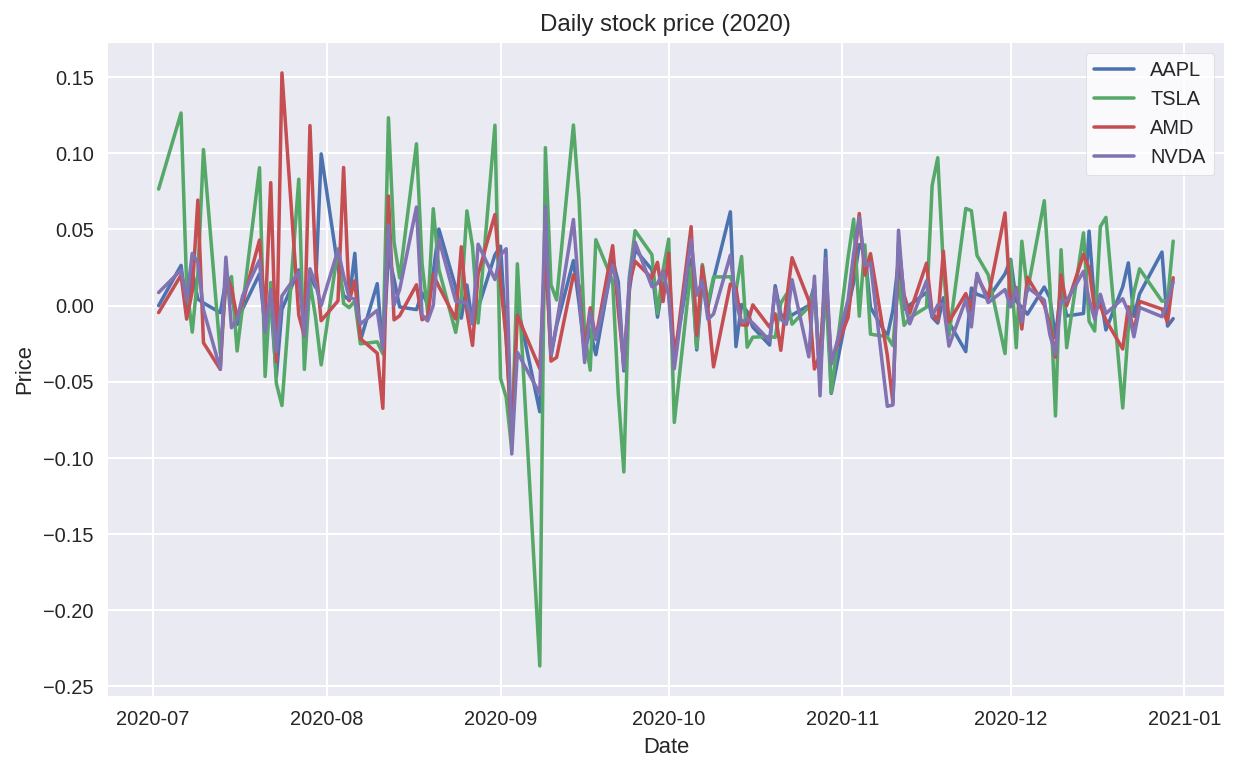

In [4]:
# Calculate log returns
returns = np.log(1 + df.pct_change()) #Plus 1 into precent changed formula
returns = returns.dropna(how = 'all', axis = 0) #Drop first date

# Plot log returns
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Daily stock price (2020)')
  plt.xlabel('Date')
  plt.ylabel('Price')

  for stock in returns.columns:
    plt.plot(returns[stock], label = stock)

  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper right')
  plt.show()

In [5]:
# Create random weights for stocks
weights = np.random.random(returns.shape[1])
weights /= np.sum(weights) #To get 100% of weights

# Calculate annualised expected return
expReturns = np.sum((returns.mean() * weights) * returns.shape[0]) #Multiply by trading days

# Calculate annualised expected volatility
expVol = np.sqrt(np.dot(weights.T,
                        np.dot(returns.cov() * returns.shape[0],
                               weights)))

# Calculate Sharpe Ratio
riskFree = 0.001

sharpeRatio = (expReturns - riskFree) / expVol

# Print results
print(f'Weights: {dict(zip(returns.columns, np.round(weights, 2)))}')
print(f'Expected return: {expReturns:.2f}')
print(f'Expected volatility: {expVol:.2f}')
print(f'Sharpe Ratio: {sharpeRatio:.2f}')

Weights: {'AAPL': 0.26, 'TSLA': 0.01, 'AMD': 0.36, 'NVDA': 0.37}
Expected return: 0.43
Expected volatility: 0.28
Sharpe Ratio: 1.54


In [6]:
# Define Sharpe Ratio function
def SharpeRatio(data, n, riskFree):
  results = []

  for i in range(n):
    
    # Simulation
    weights = np.random.random(data.shape[1])
    weights /= np.sum(weights)
    expRet = np.sum((data.mean() * weights) * data.shape[0])
    expVol = np.sqrt(np.dot(weights.T,
                            np.dot(data.cov() * data.shape[0],
                                   weights)))
    
    # Sharpe Ratio
    ratio = (expRet - riskFree) / expVol

    # Summary table
    result = {'Sharpe Ratio': [ratio],
              'Return': [expRet],
              'Volatility': [expVol]}
    
    weights = pd.DataFrame([weights], columns = data.columns)
    result = pd.DataFrame(result)
    result = pd.concat([result, weights], axis = 1)
    results.append(result)

  return pd.concat(results, axis = 0).reset_index(drop = True)

# Monte Carlo simulation
simulation = SharpeRatio(returns, 5000, 0.001)
simulation

,Sharpe Ratio,Return,Volatility,AAPL,TSLA,AMD,NVDA
0,1.591889,0.449388,0.281671,0.202368,0.063650,0.259009,0.474974
1,1.936729,0.591390,0.304839,0.169903,0.236913,0.274783,0.318402
2,2.033114,0.620331,0.304622,0.290843,0.205889,0.466608,0.036660
3,1.945980,0.613717,0.314863,0.407278,0.319322,0.024893,0.248508
4,1.900079,0.636148,0.334275,0.177191,0.363197,0.033401,0.426210
...,...,...,...,...,...,...,...
4995,1.897043,0.530163,0.278941,0.515032,0.161362,0.180088,0.143517
4996,2.078645,0.646600,0.310587,0.297336,0.291427,0.285844,0.125393
4997,1.814427,0.519149,0.285572,0.262150,0.153563,0.229848,0.354440
4998,1.956824,0.610977,0.311718,0.281249,0.300446,0.111646,0.306659


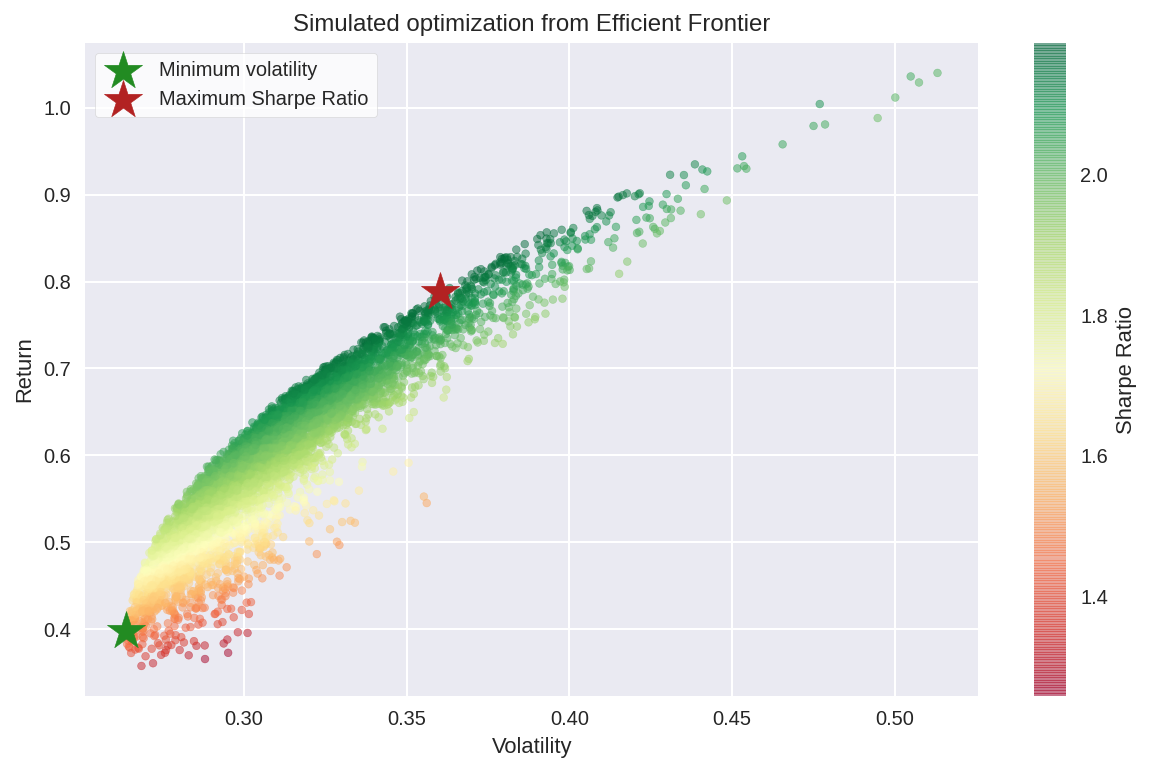

In [7]:
# Find minimum volatility
minVol = simulation.loc[simulation['Volatility'].idxmin()]

# Find maximum Sharpe Ratio
maxShp = simulation.loc[simulation['Sharpe Ratio'].idxmax()]

# Plot simulation
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Simulated optimization from Efficient Frontier')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  
  # Plot simulation
  plt.scatter(x = simulation['Volatility'], y = simulation['Return'],
              c = simulation['Sharpe Ratio'], cmap = 'RdYlGn',
              marker = 'o', s = 15, alpha = 0.5)
  
  plt.colorbar(label = 'Sharpe Ratio')
  
  # Plot minimum volatility
  plt.scatter(x = minVol['Volatility'], y = minVol['Return'],
              c = 'forestgreen', marker = '*', s = 400, label = 'Minimum volatility')

  # Plot maximum Sharpe Ratio
  plt.scatter(x = maxShp['Volatility'], y = maxShp['Return'],
              c = 'firebrick', marker = '*', s = 400, label = 'Maximum Sharpe Ratio')
  
  
  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper left')
  plt.show()

In [8]:
# Print minimum Volatility
minVol

Sharpe Ratio    1.504650
Return          0.397917
Volatility      0.263793
AAPL            0.616024
TSLA            0.004312
AMD             0.131483
NVDA            0.248181
Name: 2297, dtype: float64

In [9]:
# Print maximum Sharpe Ratio
maxShp

Sharpe Ratio    2.185703
Return          0.788247
Volatility      0.360180
AAPL            0.196952
TSLA            0.456437
AMD             0.346569
NVDA            0.000042
Name: 1894, dtype: float64

In [10]:
# Optimization
# Define Shapre Ratio function
def SharpeRatio(weights):
  weights = np.array(weights)
  expRet = np.sum((returns.mean() * weights) * returns.shape[0])
  expVol = np.sqrt(np.dot(weights.T,
                          np.dot(returns.cov() * returns.shape[0],
                                 weights)))
  ratio = (expRet - 0.001) / expVol
  results = np.array([expRet, expVol, ratio])
  return results

# Define maximum Sharpe Ratio function
def maxSharpe(weights):
  return -SharpeRatio(weights)[2] #Inversed minimum to find maximum

# Define minimum volatility function
def minVolat(weights):
  return SharpeRatio(weights)[1]

# Define constraints
def constraint(weights):
    return np.sum(weights) - 1

# Initial guess
init = returns.shape[1] * [1 / returns.shape[1]] #Equal weights

# Boundaries between 0-1
bounds = tuple((0., 1.) for i in range(returns.shape[1]))

# Constraints
constraints = {'type': 'eq', 'fun': constraint}

In [11]:
# Perform to optimize volatility
optVolFun = minimize(minVolat, init, method = 'SLSQP',
                     bounds = bounds, constraints = constraints)

# Results
print(dict(zip(stockList, optVolFun.x)))

optVol = SharpeRatio(optVolFun.x)
print(optVol)

{'AAPL': 0.5871989464624703, 'TSLA': 0.0, 'AMD': 0.12153683066302902, 'NVDA': 0.29126422287450066}
[0.39013473 0.26355417 1.47648864]


In [12]:
# Perform to optimize Sharpe Ratio
optSharpeFun = minimize(maxSharpe, init, method = 'SLSQP',
                        bounds = bounds, constraints = constraints)

# Results
print(dict(zip(stockList, optSharpeFun.x)))

optSharpe = SharpeRatio(optSharpeFun.x)
print(optSharpe)

{'AAPL': 0.1590491831837978, 'TSLA': 0.469827949476842, 'AMD': 0.3711228673393602, 'NVDA': 2.2551405187698492e-17}
[0.80249917 0.36656072 2.18653866]


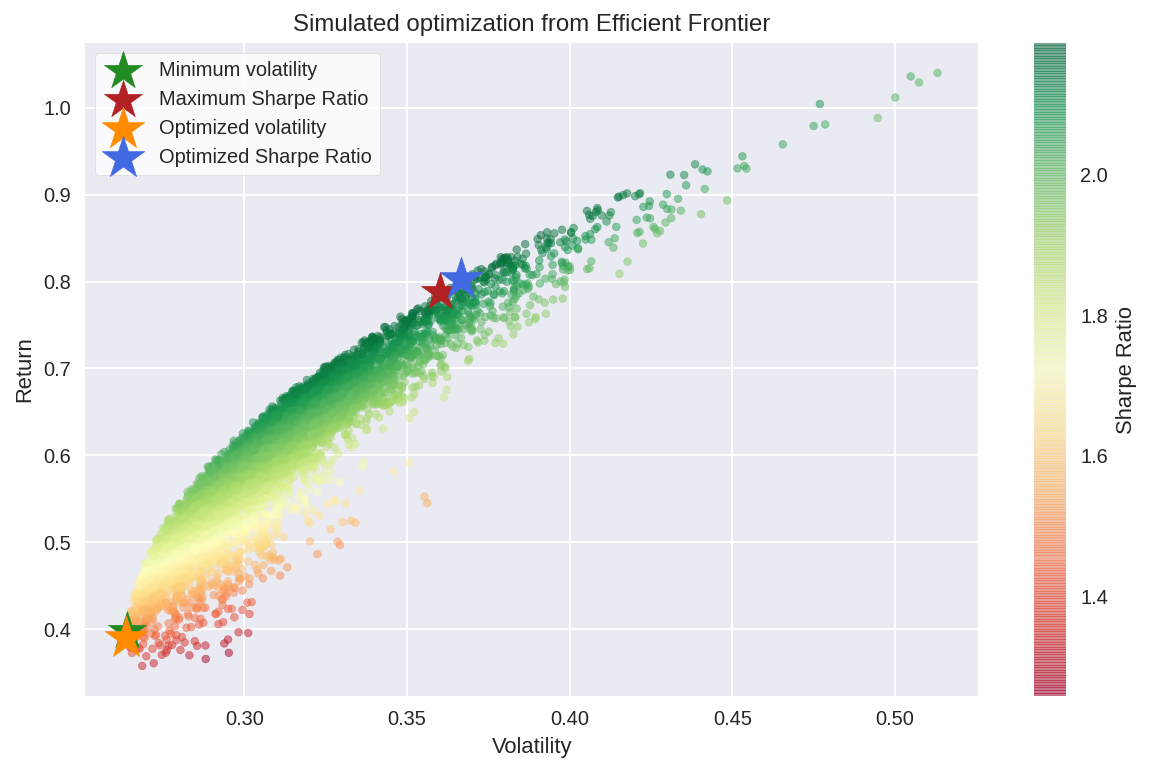

In [13]:
# Plot simulation
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Simulated optimization from Efficient Frontier')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  
  # Plot simulation
  plt.scatter(x = simulation['Volatility'], y = simulation['Return'],
              c = simulation['Sharpe Ratio'], cmap = 'RdYlGn',
              marker = 'o', s = 15, alpha = 0.5)
  
  plt.colorbar(label = 'Sharpe Ratio')
  
  # Plot minimum volatility
  plt.scatter(x = minVol['Volatility'], y = minVol['Return'],
              c = 'forestgreen', marker = '*', s = 400, label = 'Minimum volatility')

  # Plot maximum Sharpe Ratio
  plt.scatter(x = maxShp['Volatility'], y = maxShp['Return'],
              c = 'firebrick', marker = '*', s = 400, label = 'Maximum Sharpe Ratio')
  
  # Plot optimized volatility
  plt.scatter(x = optVol[1], y = optVol[0],
              c = 'darkorange', marker = '*', s = 500, label = 'Optimized volatility')

  # Plot optimized Sharpe Ratio
  plt.scatter(x = optSharpe[1], y = optSharpe[0],
              c = 'royalblue', marker = '*', s = 500, label = 'Optimized Sharpe Ratio')
  
  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper left')
  plt.show()